In [1]:
# Imports
import torch
import numpy as np
import random

# Causal_cocycle imports
from causal_cocycle.model_factory import CocycleFactory
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.optimise_new import validate, optimise
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.helper_functions import kolmogorov_distance

# Import the DGP and policy functions from BD.py
from BD import DGP, policy, new_policy

# Import configs 
from BD_cocycle_config_debug import model_config, opt_config
from BD_dgp_config import dgp_config

import matplotlib.pyplot as plt

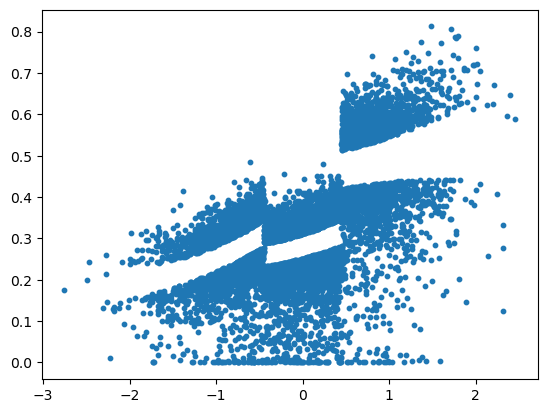

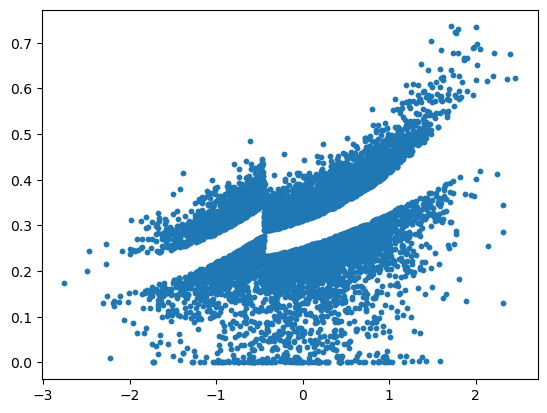

In [2]:
# Generating observatioanl data with configs
seed = 0
N = int(dgp_config['N']/2)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Z,X,Y = DGP(policy = policy,**dgp_config)
Z1,X1,Y1 = Z[:N], X[:N],Y[:N]
Z2,X2,Y2 = Z[N:], X[N:],Y[N:]
plt.scatter(Z @ dgp_config['projection_coeffs'],torch.log(1+torch.exp(-Y)), s = 10);
plt.show()

# Generating interventional data with configs
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Zint,Xint,Yint = DGP(policy = new_policy,**dgp_config)
Zint1,Xint1,Yint1 = Zint[:N], Xint[:N],Yint[:N]
Zint2,Xint2,Yint2 = Zint[N:], Xint[N:],Yint[N:]
plt.scatter(Zint @ dgp_config['projection_coeffs'],torch.log(1+torch.exp(-Yint)), s = 10);

# Random dataset shuffle
id = torch.randperm(Z.size(0))
Ztr,Xtr,Ytr = Z[id],X[id],Y[id]

In [3]:
# Cocycle model construction
input_dim = dgp_config['D']
factory = CocycleFactory(input_dim+1, model_config)
models, hyper_args = factory.build_models()
print(f"Constructed {len(models)} candidate models.")
model = models[0]

Constructed 1 candidate models.


In [4]:
# Cocycle loss construction
kernel = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel)
loss= loss_factory.build_loss("CMMD_V", X, Y, subsamples=10**4)

In [5]:
from causal_cocycle.optimise_new import optimise
losses, avg_val_loss = optimise(model,
                    loss,
                    Xtr,
                    Ytr, 
                    inputs_val=None,
                    outputs_val=None,
                    learn_rate=1e-3, 
                    epochs=100,
                    weight_decay=0,
                    batch_size=64,
                    val_batch_size=1024,
                    scheduler=False, 
                    schedule_milestone=10, 
                    lr_mult=0.90, 
                    print_=True, 
                    plot=False,
                    likelihood_param_opt=False,
                    likelihood_param_lr=0.01,
                    loss_val=None)

Epoch 1/100, Training Loss: -0.5344
Epoch 2/100, Training Loss: -0.5414
Epoch 3/100, Training Loss: -0.5541
Epoch 4/100, Training Loss: -0.5552
Epoch 5/100, Training Loss: -0.5581
Epoch 6/100, Training Loss: -0.5585
Epoch 7/100, Training Loss: -0.5609
Epoch 8/100, Training Loss: -0.5599
Epoch 9/100, Training Loss: -0.5549
Epoch 10/100, Training Loss: -0.5626
Epoch 11/100, Training Loss: -0.5622
Epoch 12/100, Training Loss: -0.5629
Epoch 13/100, Training Loss: -0.5602
Epoch 14/100, Training Loss: -0.5649
Epoch 15/100, Training Loss: -0.5577
Epoch 16/100, Training Loss: -0.5614
Epoch 17/100, Training Loss: -0.5600
Epoch 18/100, Training Loss: -0.5599
Epoch 19/100, Training Loss: -0.5601
Epoch 20/100, Training Loss: -0.5695
Epoch 21/100, Training Loss: -0.5704
Epoch 22/100, Training Loss: -0.5688
Epoch 23/100, Training Loss: -0.5689
Epoch 24/100, Training Loss: -0.5667
Epoch 25/100, Training Loss: -0.5653
Epoch 26/100, Training Loss: -0.5689
Epoch 27/100, Training Loss: -0.5669
Epoch 28/1

## Debug

In [10]:
# Extract predicted functions and true functions
shift_pred = model.conditioner.layers[0]
scale_pred = model.conditioner.layers[1]
from BD import shift, scale

In [11]:
# Get test points
from torch.distributions import Normal
ntest = 1000
Ztest = Normal(0,1.5).sample((1000, dgp_config['D']))
Xtest = torch.column_stack((policy(Ztest),Ztest))

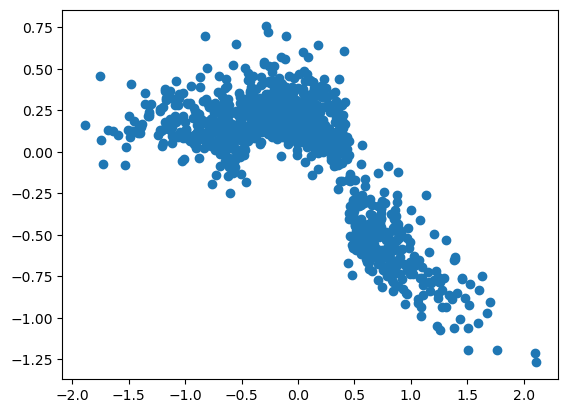

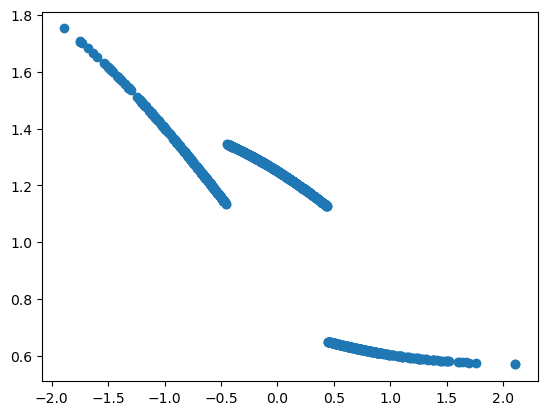

In [12]:
plt.scatter(Ztest @  dgp_config['projection_coeffs'], shift_pred(Xtest).detach())
plt.show()
plt.scatter(Ztest @ dgp_config['projection_coeffs'], shift(Ztest,policy, dgp_config['projection_coeffs']).detach())

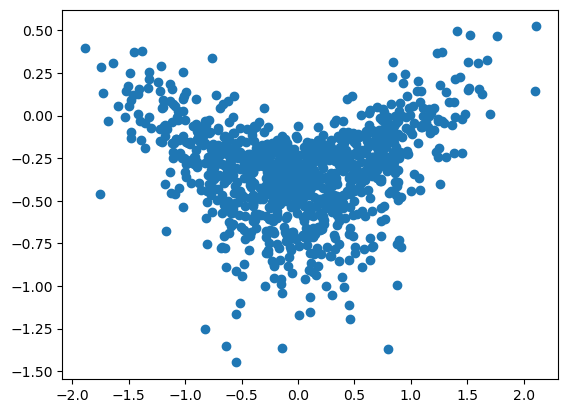

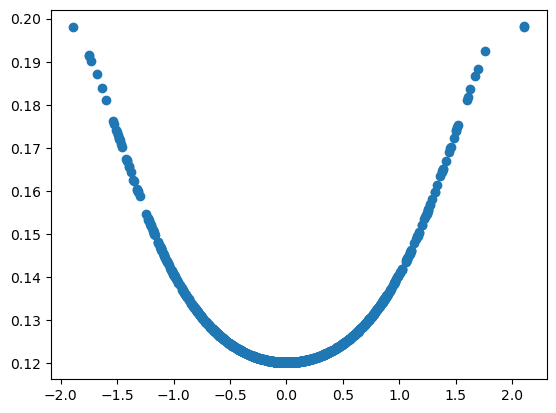

In [13]:
plt.scatter(Ztest @  dgp_config['projection_coeffs'], scale_pred(Xtest).detach())
plt.show()
plt.scatter(Ztest @ dgp_config['projection_coeffs'], scale(Ztest,dgp_config['projection_coeffs']).detach())